Thinkful Bootcamp Course

Author: Ian Heaton

Email: iheaton@gmail.com

Mentor: Nemanja Radojkovic

Date: 2017/05/28


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import scipy

from time import time
from IPython.display import display
from sklearn.cluster import KMeans
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.preprocessing import normalize

%matplotlib inline

sb.set_style('darkgrid')
my_dpi = 96

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Boston Marathon


## Question:

What can Unsupervised Clustering tell us about the 2014 Boston Marathon?

### Data:

Boston Marathon Raw Data

Repository contains all of the data on the Boston Marathon available from baa.org. Race results data can be found at this [website](https://github.com/llimllib/bostonmarathon/tree/master/results). Data used in the notebook is from 2014.


### Content:

+ 10K : Time in minutes and seconds of runner at 10K point of the 42.195K race.
+ Name : Name of Participant in race.
+ Divison : ?
+ 25K :  Time in minutes and seconds of runner at 25K point of the 42.195K race.
+ Gender : Sex of participant.
+ Age : Age in years of participant at the time of race.
+ Official : Finishing time of participant in minutes and seconds.
+ Bib : Bib number which are a tool for race directors to tell these thousands of runners apart and to simplify the seemingly impossible task of getting a time for each and every one of these runners.
+ Gender Divison : ? (Appears to have the same value as the Divison feature for an observation).
+ CTZ (Citizenship) : Only available if different from country of residence.
+ 35K : Time in minutes and seconds of runner at 35K point of the 42.195K race.
+ Overall : Overall finish position.
+ Pace : Average kilometer time in minutes and seconds.
+ State : United States state abbreviation, only available if runner’s country of origin is the US.
+ 30K : Time in minutes and seconds of runner at 35K point of the 42.195K race.
+ 5K : Time in minutes and seconds of runner at 5K point of the 42.195K race.
+ Half : Time in minutes and seconds of runner at half way point (21.0975) of the 42.195K race.
+ 20K : Time in minutes and seconds of runner at 20K point of the 42.195K race.
+ Country : Participant country of origin.
+ City : City of Residence of participant.
+ 40K : Time in minutes and seconds of runner at 40K point of the 42.195K race.

In [2]:
# Read CSV containing text data
data_file = '/media/ianh/space/ThinkfulData/BostonMarathon/2014_results.csv'
marathon = pd.read_csv(data_file)
print("\nNumbr of Observations : %d\n" % (marathon.shape[0]))
print("Number of Features : %d" % (marathon.shape[1]))


Numbr of Observations : 31984

Number of Features : 21


### Preprocessing and exploratory data analysis

In [3]:
# Check for missing data
print("%s\n" % (marathon.isnull().sum()))

# Lets ensure that all columns are of the expected type object and int (or float)
print("\n%s\n" % (marathon.dtypes))

10k              0
name             0
division         0
25k              0
gender           0
age              0
official         0
bib              0
genderdiv        0
ctz          30740
35k              0
overall          0
pace             0
state         2576
30k              0
5k               0
half             0
20k              0
country          0
city             1
40k              0
dtype: int64


10k           object
name          object
division       int64
25k           object
gender        object
age            int64
official     float64
bib           object
genderdiv      int64
ctz           object
35k           object
overall        int64
pace         float64
state         object
30k           object
5k            object
half          object
20k           object
country       object
city          object
40k           object
dtype: object



First some of the text features will be dropped from the Data frame. Mapping these categorical features to integer values would not make sense.  The integer values become surrogates for the label and what does the difference or distance  between to labels mean? 
These include name, bib, ctz, country, city and state. In addition, the features state and ctz have too many null values to be of use. Second, all time related features will be converted to float so that they may be used in the analysis. Then drop any observations that have Nan values.

We also create some color mappings for gender and continent. It is hoped that viewing the resulting clusters by gender and or the continent that runner’s country resides in will help make some sense of the clustering. 

In [4]:
# convert timing string (object) features to floats
marathon = marathon.replace(to_replace='-', value='')
marathon['10k'] = marathon['10k'].convert_objects(convert_numeric=True)
marathon['25k'] = marathon['25k'].convert_objects(convert_numeric=True)
marathon['30k'] = marathon['30k'].convert_objects(convert_numeric=True)
marathon['35k'] = marathon['35k'].convert_objects(convert_numeric=True)
marathon['5k'] = marathon['5k'].convert_objects(convert_numeric=True)
marathon['20k'] = marathon['20k'].convert_objects(convert_numeric=True)
marathon['40k'] = marathon['40k'].convert_objects(convert_numeric=True)
marathon['half'] = marathon['half'].convert_objects(convert_numeric=True)

# Create color maps for some of the categorical data
# Gender
SEX_COLOR_MAP = {'M' : 'b', 'F' : 'pink'}

gender_color = [SEX_COLOR_MAP[l] for l in marathon.gender]

# Country transformed to Continents

# map country names to Continents
country_mapping = {'JPN':'AS', 'KEN':'AF', 'RSA':'AF', 'ETH':'AF', 'SUI':'EU', 'USA':'NA', 'FRA':'EU', 
                   'CAN':'NA', 'ESP':'EU','POL':'EU', 'RUS':'EU', 'BLR':'EU', 'MAR':'AF', 'UKR':'EU',
                   'BRA':'SA', 'THA':'AS', 'CHN':'AS', 'ITA':'EU','GER': 'EU', 'GBR':'EU', 'AUS':'OC', 
                   'SWE':'EU', 'GRE':'EU', 'SLO':'EU', 'IRL':'EU', 'KOR':'AS', 'ARG':'SA','COL':'SA',
                   'NED':'EU', 'ISR':'AS', 'CZE':'EU', 'NOR':'EU', 'AUT':'EU', 'CRC':'SA', 'MEX':'SA', 
                   'GUA':'SA', 'SIN':'AS', 'DEN':'EU', 'HUN':'EU', 'BEL':'EU', 'FIN':'EU', 'CHI':'SA',
                   'ISL':'EU', 'VEN':'SA', 'DOM':'SA','PER':'SA', 'HKG':'AS', 'SVK':'EU', 'NZL':'OC',
                   'TPE':'AS', 'PHI':'AS', 'CAY':'SA', 'POR':'EU', 'UAE':'AS','IND':'AS', 'PAN':'AS', 
                   'ROU':'EU', 'LUX':'EU', 'ESA':'SA', 'TRI':'SA', 'MAS':'AS', 'VGB':'SA', 'EGY':'AF',
                   'BRN':'AS', 'EST':'EU', 'ECU':'SA', 'LIE':'EU', 'TUR':'AS', 'BOL':'SA', 'BAR':'SA',
                   'URU':'SA', 'QAT':'AS', 'INA':'AS', 'BER':'NA', 'TAN':'AF', 'BAH':'NA', 'CRO':'EU',
                   'ZIM':'AF'}

marathon['continent'] = marathon.country.map(country_mapping)

# Create mapping of continents to colors
CONTINENT_COLOR_MAP = {'AS' : 'sienna', 'AF' : 'gold', 'EU': 'sage', 'OC':'lavender', 'SA':'yellow',
                       'NA':'royalblue'}

continent_color = [CONTINENT_COLOR_MAP[l] for l in marathon.continent]

# drop features name, bib etc.
features_to_drop = ['name', 'bib', 'ctz', 'state', 'genderdiv', 'city', 'gender', 'country', 'continent']
marathon = marathon.drop(features_to_drop, axis=1)

marathon.head()

10k  division    25k  age  official     35k  overall  pace    30k     5k  \
0  17.37         8  47.67   47     85.25   71.40        8  3.27  59.18   8.02   
1  32.58         1  82.43   33    138.95  116.37       21  5.30  99.33  16.22   
2  16.62         1  45.80   41     80.60   67.42        1  3.08  56.45   7.75   
3  32.57         3  82.43   24    140.58  116.37       27  5.37  99.33  16.20   
4  17.12         2  46.37   40     81.23   67.83        2  3.10  57.03   8.02   

    half    20k     40k  
0  39.72  37.65   80.43  
1  69.47  65.83  132.10  
2  38.03  36.10   76.10  
3  69.47  65.83  132.95  
4  38.60  36.58   76.72

In [5]:
# Create new features, create time deltas between check points
# Half Marathon is 21.0975 K
# Marathon is 42.195 K

marathon = marathon.dropna()

marathon['10Kdelta'] = marathon['10k'] - marathon['5k']  # 5k difference
marathon['20Kdelta'] = marathon['20k'] - marathon['10k'] # 10K difference
marathon['30Kdelta'] = marathon['30k'] - marathon['20k'] # 10k difference 
marathon['35Kdelta'] = marathon['35k'] - marathon['30k'] # 5k difference
marathon['40Kdelta'] = marathon['40k'] - marathon['35k'] # 5k difference
marathon['2ndHalfdelta'] = marathon['official'] - marathon['half'] # 21.0975k difference

marathon.head()

10k  division    25k  age  official     35k  overall  pace    30k     5k  \
0  17.37         8  47.67   47     85.25   71.40        8  3.27  59.18   8.02   
1  32.58         1  82.43   33    138.95  116.37       21  5.30  99.33  16.22   
2  16.62         1  45.80   41     80.60   67.42        1  3.08  56.45   7.75   
3  32.57         3  82.43   24    140.58  116.37       27  5.37  99.33  16.20   
4  17.12         2  46.37   40     81.23   67.83        2  3.10  57.03   8.02   

    half    20k     40k  10Kdelta  20Kdelta  30Kdelta  35Kdelta  40Kdelta  \
0  39.72  37.65   80.43      9.35     20.28     21.53     12.22      9.03   
1  69.47  65.83  132.10     16.36     33.25     33.50     17.04     15.73   
2  38.03  36.10   76.10      8.87     19.48     20.35     10.97      8.68   
3  69.47  65.83  132.95     16.37     33.26     33.50     17.04     16.58   
4  38.60  36.58   76.72      9.10     19.46     20.45     10.80      8.89   

   2ndHalfdelta  
0         45.53  
1         69.48  
2         42.57  
3         71.11  
4         42.63

Lastly, we normalize the data or rescale the features to a range of [0, 1] and determine the final number of observations and features.


Numbr of Observations Remaining : 31649


Numbr of Features Remaining : 19



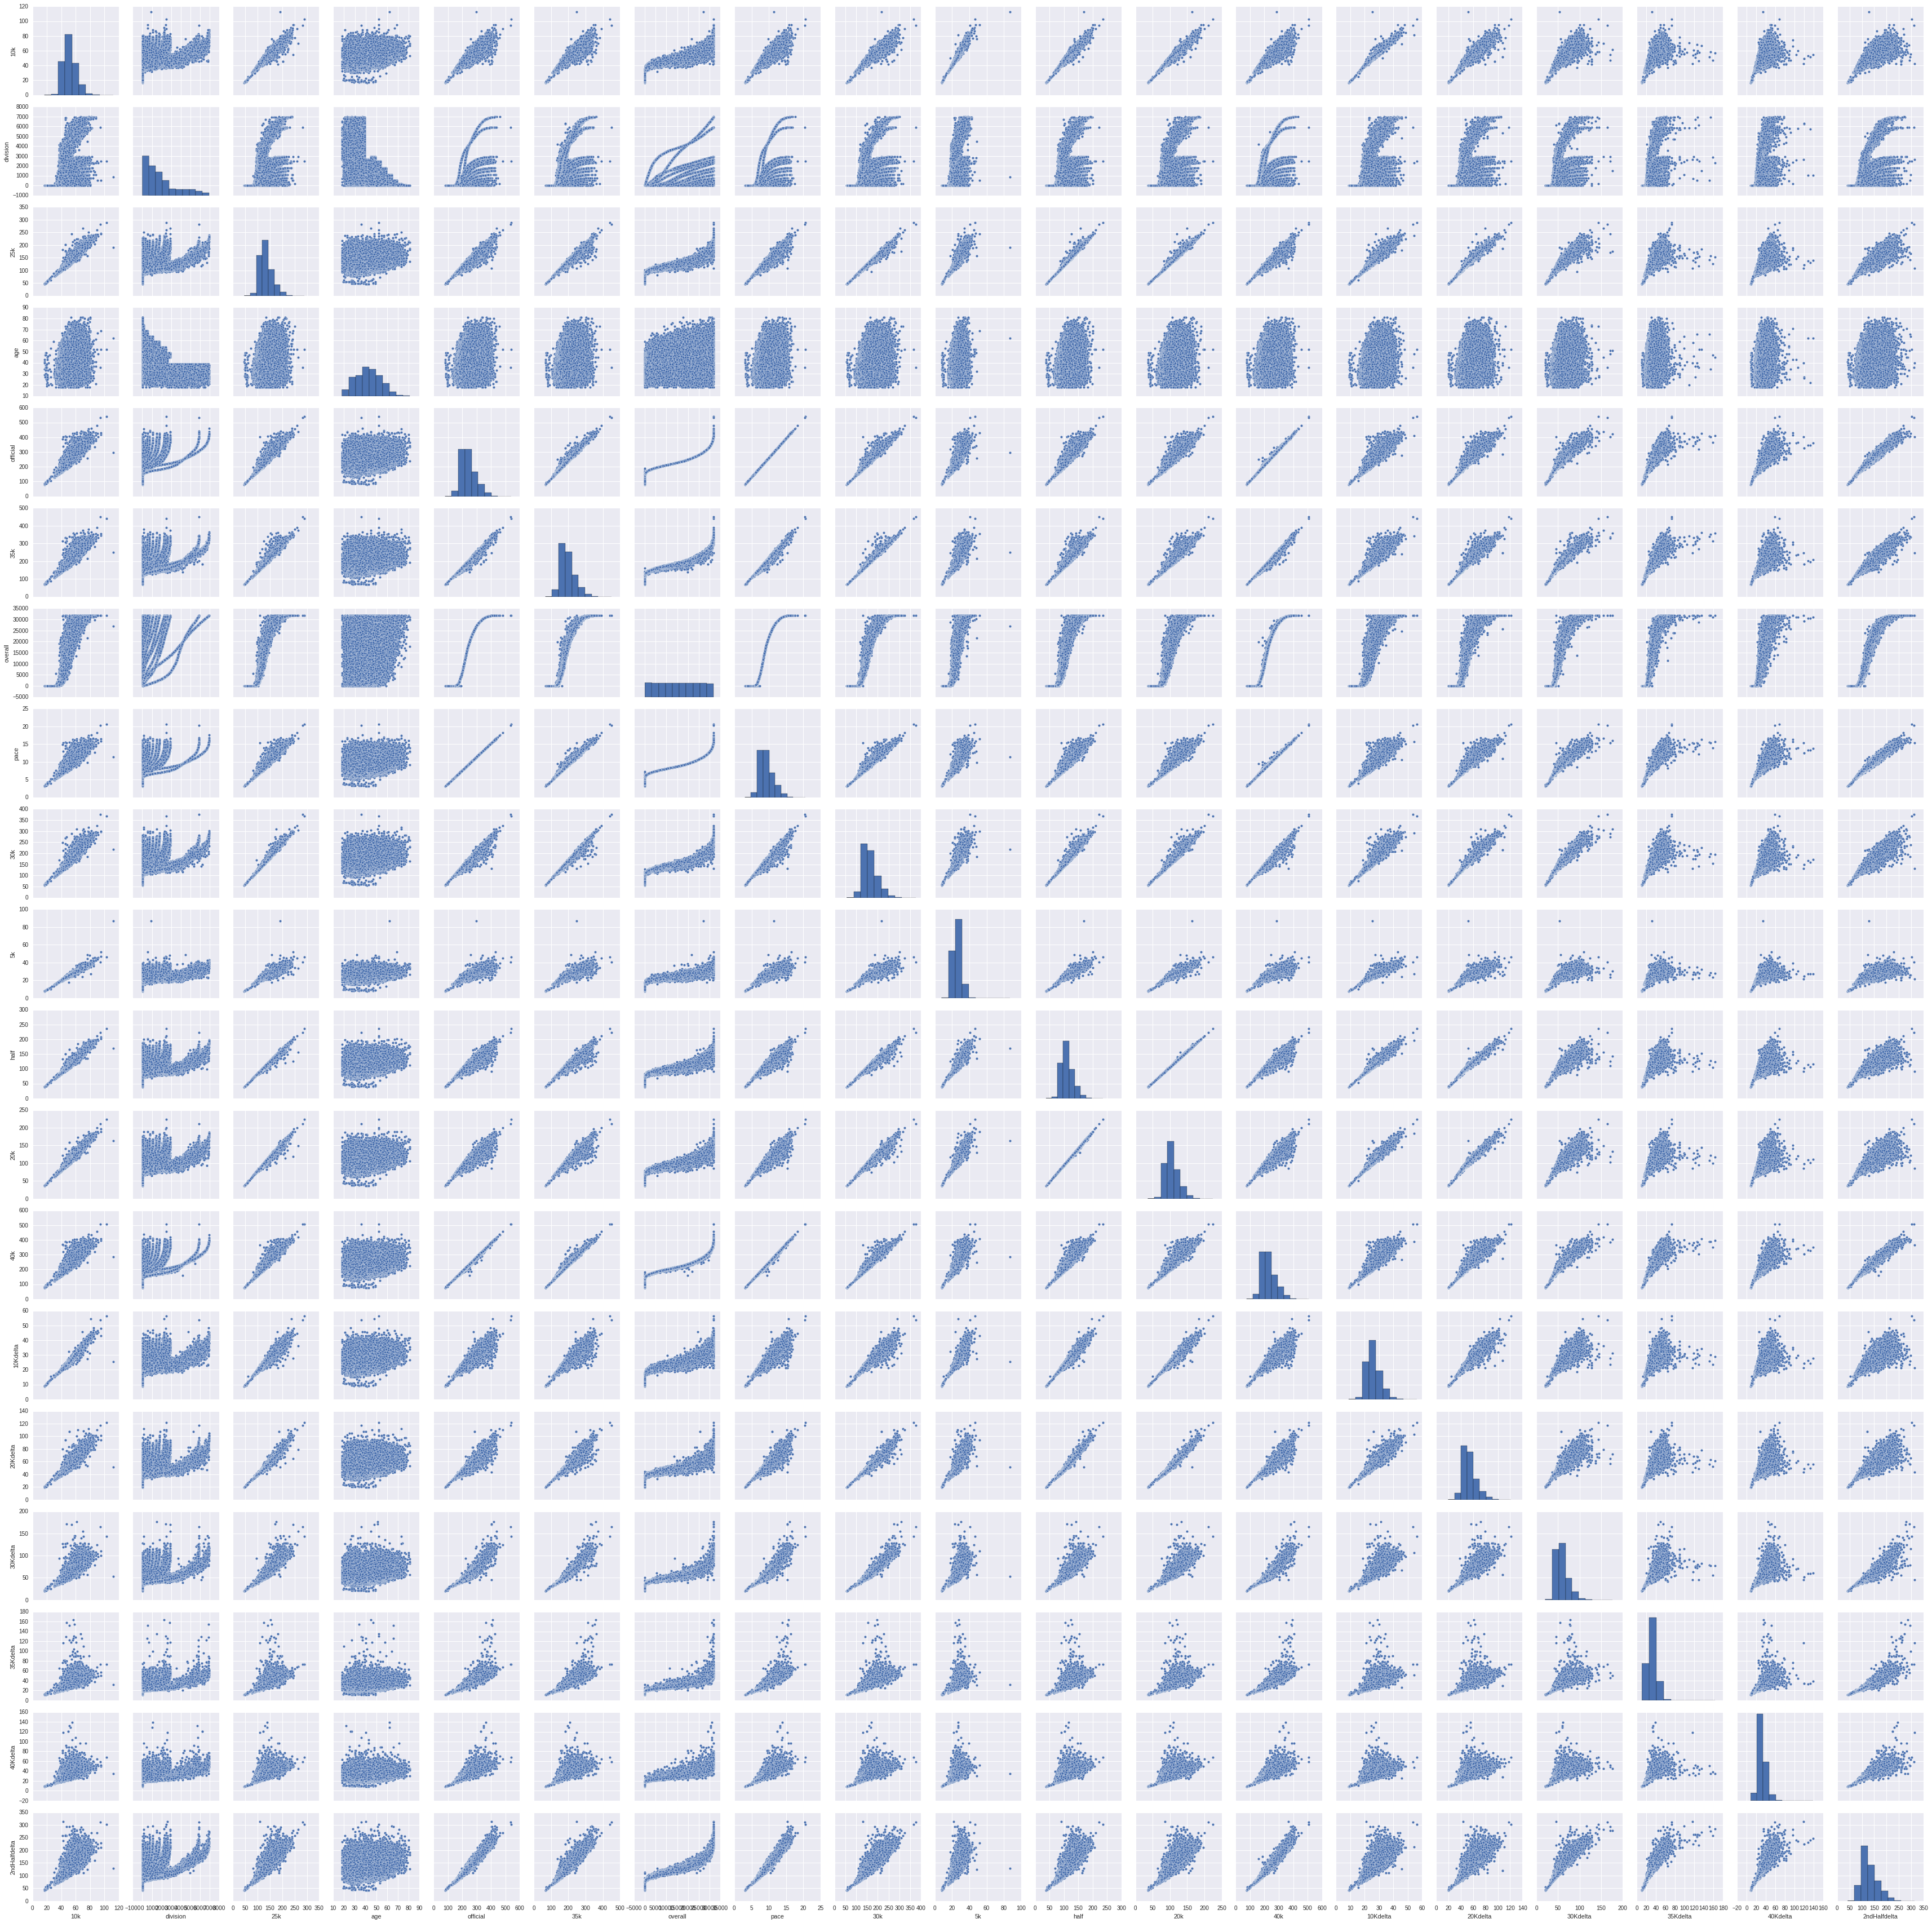

In [6]:
__ = sb.pairplot(marathon)
print("\nNumbr of Observations Remaining : %d\n" % (marathon.shape[0]))
print("\nNumbr of Features Remaining : %d\n" % (marathon.shape[1]))

X = normalize(marathon)

In [7]:
"""
Function that times and performs clustering evaluation.
If data has target variable adjusted rand index, validity
measure and Silhouette coefficient are computed and sent 
to standard output otherwise only the time and Silhouette
coefficient are computed. 

    Args:
        estimator (class instance): Instance of a clustering model. 
        name (str):                 String containing the name of the clustering algorithm.
        data (numpy array):         A matrix of features and observations that the clustering 
                                    algorithm will be run against.
        labels (numpy array):       A vector of a target variables, the expected cluster label 
                                    for each observation.
        sample_size (int):          The number of point samples to use when computing the Silhouette Coefficient.

    Returns:
        results (dict) : Response classes used by urllib

     
"""
def bench_cluster(estimator, name, data, labels=None, sample_size=300):
    results = {'time':0, 'homo':0, 'compl':0, 'v-meas':0, 'ARI':0, 'silhouette':0}
    print(79 * '_')
    t0 = time()
    estimator.fit(data)
    results['time'] = (time() - t0)
    results['silhouette'] = metrics.silhouette_score(data, estimator.labels_, metric='euclidean', 
                                                     sample_size=sample_size)
    if labels is not None:
        print('% 9s' % 'init''         time   homo   compl   v-meas   ARI   silhouette')
        results['homo'] = metrics.homogeneity_score(labels, estimator.labels_)
        results['compl'] = metrics.completeness_score(labels, estimator.labels_)
        results['v-meas'] = metrics.v_measure_score(labels, estimator.labels_)
        results['ARI'] = metrics.adjusted_rand_score(labels, estimator.labels_)
        print('%s % 7.2fs % 5.3f % 5.3f % 7.3f % 7.3f % 7.3f'% (name, results['time'], results['homo'],
                                                                      results['compl'], results['v-meas'],
                                                                      results['ARI'], results['silhouette']))
    else:
        print('% 13s' % 'init''         time  silhouette')
        print('%s % 7.2fs % 7.3f'% (name, results['time'], results['silhouette']))
    print(79 * '_')
    return results

## Mean-shift Model

In [8]:
bandwidth = estimate_bandwidth(X, quantile=0.3)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
__ = bench_cluster(ms, 'Mean-Shift', X, sample_size=15000)

# Extract cluster assignments for each data point.
labels = ms.labels_

LABEL_COLOR_MAP = {0 : 'r', 1 : 'c', 2 : 'b', 3: 'm'}

label_color = [LABEL_COLOR_MAP[l] for l in labels]
# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

_______________________________________________________________________________
init         time  silhouette
Mean-Shift    0.78s   0.761
_______________________________________________________________________________
Number of estimated clusters: 2


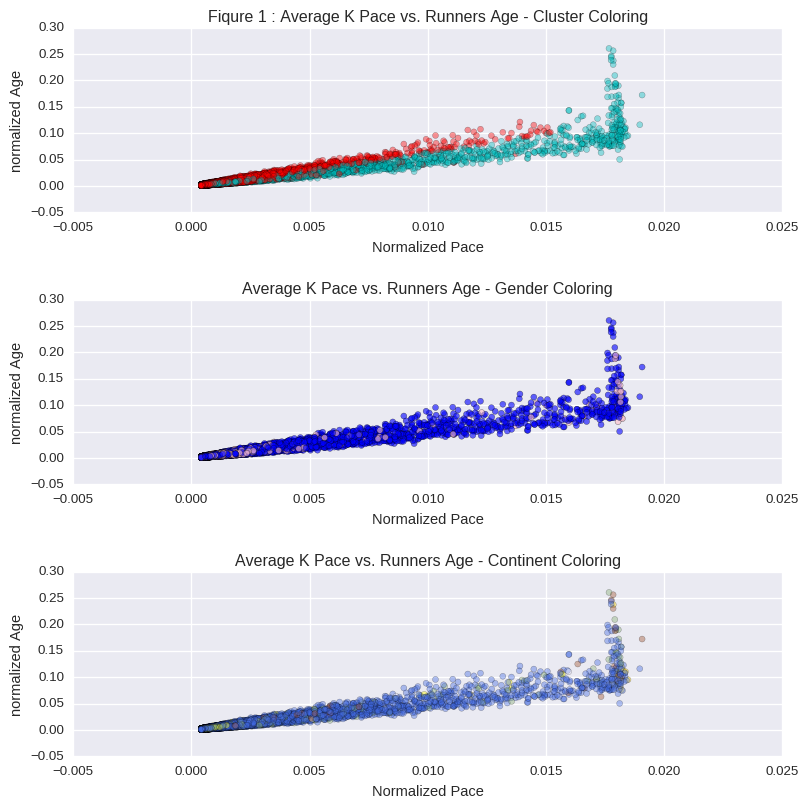

In [22]:
# Plot of Pace vs. Runner's Age
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)

plt.figure(1)
ax1 = plt.subplot(311)
ax1.set_title('Fiqure 1 : Average K Pace vs. Runners Age - Cluster Coloring')
ax1.set_xlabel('Normalized Pace')
ax1.set_ylabel('normalized Age')
__ = ax1.scatter(X[:, 7], X[:, 3], c=label_color, alpha=0.4)

ax2 = plt.subplot(312)
ax2.set_title('Average K Pace vs. Runners Age - Gender Coloring')
ax2.set_xlabel('Normalized Pace')
ax2.set_ylabel('normalized Age')
__ = ax2.scatter(X[:, 7], X[:, 3], c=gender_color, alpha=0.6)

ax3 = plt.subplot(313)
ax3.set_title('Average K Pace vs. Runners Age - Continent Coloring')
ax3.set_xlabel('Normalized Pace')
ax3.set_ylabel('normalized Age')
__ = ax3.scatter(X[:, 7], X[:, 3], c=continent_color, alpha=0.4)
plt.tight_layout(pad=0.4, h_pad=2.0)

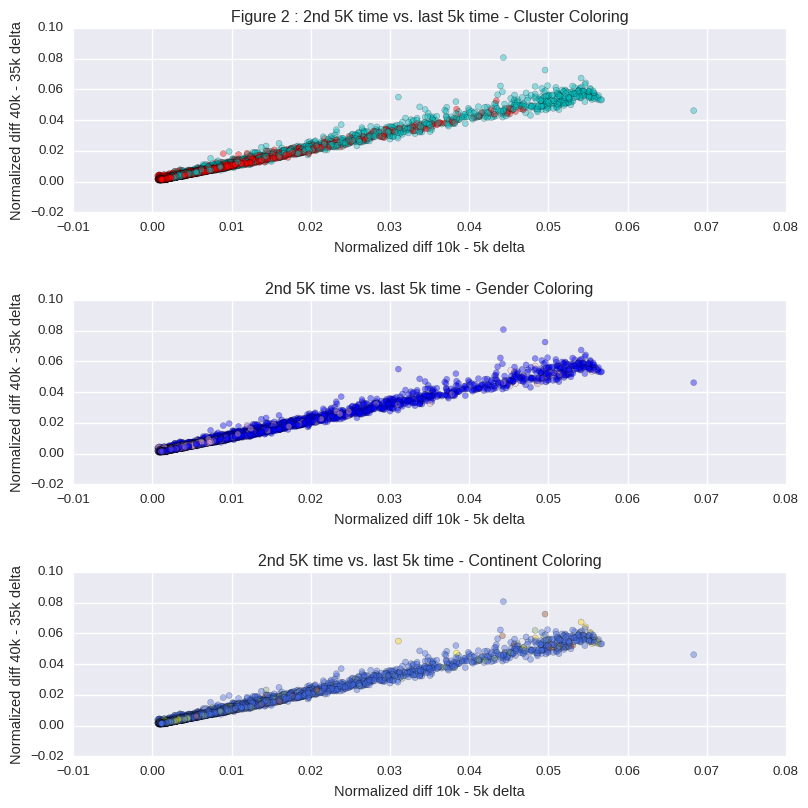

In [24]:
# Plot of 10kdelta (2nd 5k) time vs. 40Kdelta (8th 5k)
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
plt.figure(1)
ax1 = plt.subplot(311)
ax1.set_title('Figure 2 : 2nd 5K time vs. last 5k time - Cluster Coloring')
ax1.set_xlabel('Normalized diff 10k - 5k delta')
ax1.set_ylabel('Normalized diff 40k - 35k delta')
__ = ax1.scatter(X[:, 13], X[:, 17], c=label_color, alpha=0.4)

ax2 = plt.subplot(312)
ax2.set_title('2nd 5K time vs. last 5k time - Gender Coloring')
ax2.set_xlabel('Normalized diff 10k - 5k delta')
ax2.set_ylabel('Normalized diff 40k - 35k delta')
__ = ax2.scatter(X[:, 13], X[:, 17], c=gender_color, alpha=0.4)

ax3 = plt.subplot(313)
ax3.set_title('2nd 5K time vs. last 5k time - Continent Coloring')
ax3.set_xlabel('Normalized diff 10k - 5k delta')
ax3.set_ylabel('Normalized diff 40k - 35k delta')
__ = ax3.scatter(X[:, 13], X[:, 17], c=continent_color, alpha=0.4)
plt.tight_layout(pad=0.4, h_pad=2.0)

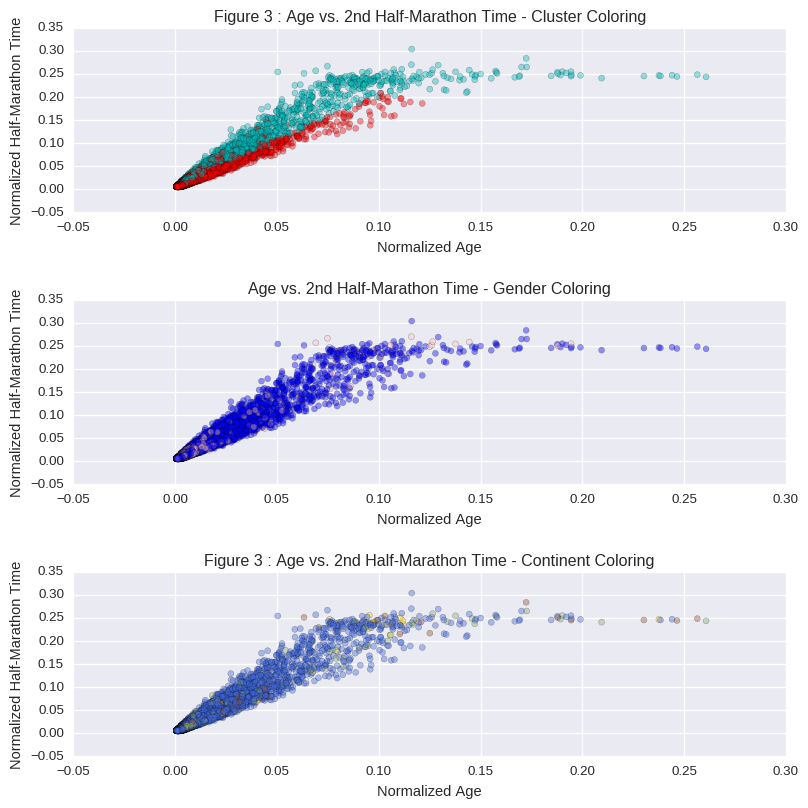

In [25]:
# Plot of Age vs 2nd Half Marathon Time
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
plt.figure(1)
ax1 = plt.subplot(311)
ax1.set_title('Figure 3 : Age vs. 2nd Half-Marathon Time - Cluster Coloring')
ax1.set_xlabel('Normalized Age')
ax1.set_ylabel('Normalized Half-Marathon Time')
__ = ax1.scatter(X[:, 3], X[:, 18], c=label_color, alpha=0.4)

ax2 = plt.subplot(312)
ax2.set_title('Age vs. 2nd Half-Marathon Time - Gender Coloring')
ax2.set_xlabel('Normalized Age')
ax2.set_ylabel('Normalized Half-Marathon Time')
__ = ax2.scatter(X[:, 3], X[:, 18], c=gender_color, alpha=0.4)

ax3 = plt.subplot(313)
ax3.set_title('Figure 3 : Age vs. 2nd Half-Marathon Time - Continent Coloring')
ax3.set_xlabel('Normalized Age')
ax3.set_ylabel('Normalized Half-Marathon Time')
__ = ax3.scatter(X[:, 3], X[:, 18], c=continent_color, alpha=0.4)
plt.tight_layout(pad=0.4, h_pad=2.0)

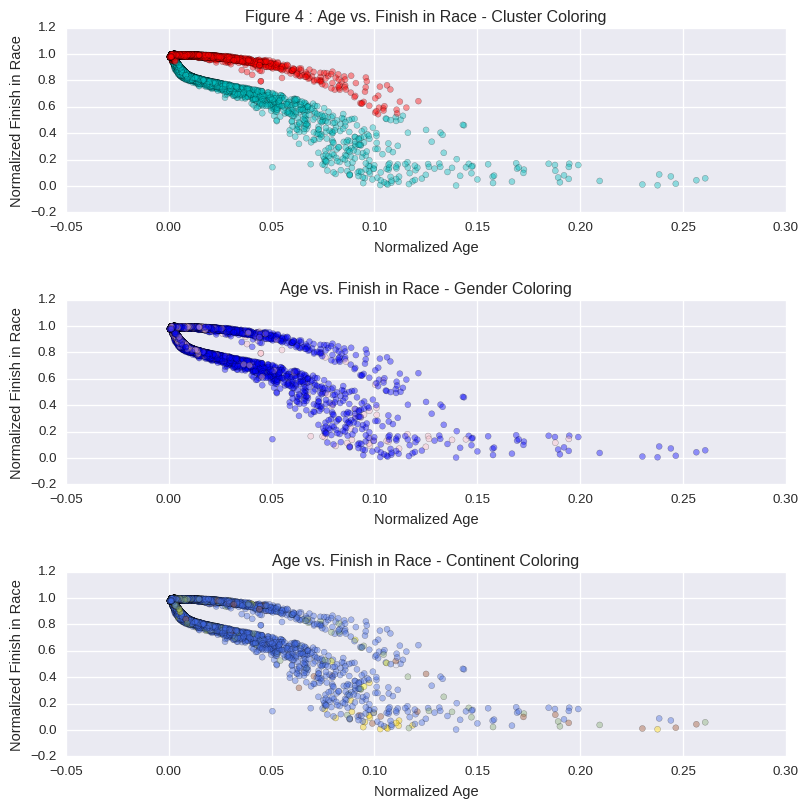

In [29]:
# Plot of Age vs. Placement in race
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
plt.figure(1)
ax1 = plt.subplot(311)
ax1.set_title('Figure 4 : Age vs. Finish in Race - Cluster Coloring')
ax1.set_xlabel('Normalized Age')
ax1.set_ylabel('Normalized Finish in Race')
__ = ax1.scatter(X[:, 3], X[:, 6], c=label_color, alpha=0.4)

ax2 = plt.subplot(312)
ax2.set_title('Age vs. Finish in Race - Gender Coloring')
ax2.set_xlabel('Normalized Age')
ax2.set_ylabel('Normalized Finish in Race')
__ = ax2.scatter(X[:, 3], X[:, 6], c=gender_color, alpha=0.4)

ax3 = plt.subplot(313)
ax3.set_title('Age vs. Finish in Race - Continent Coloring')
ax3.set_xlabel('Normalized Age')
ax3.set_ylabel('Normalized Finish in Race')
__ = ax3.scatter(X[:, 3], X[:, 6], c=continent_color, alpha=0.4)
plt.tight_layout(pad=0.4, h_pad=2.0)

## Discussion

There different clustering models were run on the Marathon results. Mean-Shift clustering was favored over K-Means clustering.  With Mean-Shift the number of clusters sought does not have to be specified.  The point of this challenge was exploratory, find new associations within the racing results.  The Mean Shift model produced a higher Silhouette coefficient value than the K-Means model, 0.761 compared to a value of 0.560.  Spectral Clustering used a little over 9GiB of memory and eventually terminated with a memory error. My virtual machine has 2 cores and 11 GiB of memory allocated and this was not enough to complete Spectral cluster to completion. 

Although there is no way to attain why the clustering algorithm grouped the observations the way it did or that the clustering makes any sense, the viewing of the different plots with different color maps was an attempt gleam some information into the grouping. 

The Mean-Shift model found 2 Clusters.  The assigning of clusters does not appear to be specific to the sex of the runner or the continent that the runner is from.  

Figure 1 shows the plotting of Age and average kilometer pace.  All values shown on the axis of plots are normalized.  Those groups depicted by the colors purple and red have the fastest pace and appear to be younger in age. Interesting that the cone of data points is stratified by red then purple while the cyan and blue clusters are very district in their positioning on the plot.

Figure 2 plots the time of the 2nd 5K and the last 5K of the race.  The one cluster given the red color is very tightly grouped while the 2nd group starts to scatter somewhat as the times for two 5 kilometer portions increase.  The use of gender and continent mapping does not reveal any insight into the clusters. 

